In [1]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import openpyxl

In [2]:
class LSTMAutoencoder:
    def __init__(self, timesteps):
        self.timesteps = timesteps
        self.features = None
        self.scaler = StandardScaler()
        self.model = None
        self.threshold = None  

    def create_sequences(self, data):
        """Creates overlapping sequences from data"""
        sequences = [data[i:i + self.timesteps] for i in range(len(data) - self.timesteps + 1)]
        return np.array(sequences)

    def build_model(self):
        """Defines the LSTM autoencoder architecture"""
        inputs = keras.Input(shape=(self.timesteps, self.features))
        x = layers.LSTM(24, activation='tanh', return_sequences=True)(inputs)
        encoded = layers.LSTM(6, activation='tanh', return_sequences=False)(x)
        x = layers.RepeatVector(self.timesteps)(encoded)
        x = layers.LSTM(6, activation='tanh', return_sequences=True)(x)
        x = layers.LSTM(24, activation='tanh', return_sequences=True)(x)
        decoded = layers.TimeDistributed(layers.Dense(self.features))(x)

        model = keras.Model(inputs, decoded)
        model.compile(optimizer='adam', loss='mae')
        return model  

    def preprocess(self, data):
        """Scales and converts data into sequences"""
        if isinstance(data, pd.DataFrame):
            data = data.values
            
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        
        if self.features is None:
            self.features = data.shape[1]
        
        data = self.scaler.fit_transform(data)
        return self.create_sequences(data)

    def train(self, data, epochs=50, batch=64, val_split=0.2):
        """Trains the LSTM autoencoder"""
        X = self.preprocess(data)
        X_train, X_val = train_test_split(X, test_size=val_split, shuffle=False)

        self.model = self.build_model()

        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        start = time.time()
        history = self.model.fit(X_train, X_train, 
            epochs=epochs, batch_size=batch,
            validation_data=(X_val, X_val), 
            callbacks=[early_stop], shuffle=True)
        print(f"Training Time: {time.time() - start:.2f}s")

        # Compute threshold dynamically without the typical "mean + 3*std"
        val_errors = np.abs(self.model.predict(X_val) - X_val).mean(axis=(1, 2))
        self.threshold = np.percentile(val_errors, 95)  

        return val_errors
    
    def plot_anomalies(self, val_errors, anomaly_errors):
        """Plots anomaly detection results"""
        plt.figure(figsize=(12, 6))
        
        # Plot validation errors distribution
        plt.subplot(1, 2, 1)
        plt.hist(val_errors, bins=50, alpha=0.7, label='Validation Errors')
        plt.axvline(self.threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
        plt.title('Validation Errors Distribution')
        plt.xlabel('Reconstruction Error')
        plt.ylabel('Frequency')
        plt.legend()
        
        # Plot anomaly errors
        plt.subplot(1, 2, 2)
        plt.plot(anomaly_errors, label='Reconstruction Errors')
        plt.axhline(self.threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
        plt.title('Anomaly Detection Errors')
        plt.xlabel('Sequence Index')
        plt.ylabel('Reconstruction Error')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    def detect_anomalies(self, data):
        """Detects anomalies"""
        if self.model is None or self.threshold is None:
            raise RuntimeError("Train the model first.")
        
        sequences = self.preprocess(data)
        errors = np.abs(self.model.predict(sequences) - sequences).mean(axis=(1, 2))
        return errors, errors > self.threshold

In [7]:
def load_csv(folderpath):
    """Loads CSV and extracts required columns"""
    if not os.path.exists(folderpath):
        raise FileNotFoundError(f"Folder {folderpath} not found.")
    
    filtered_dataframes = []

    features = [
        "actual_q", 
        "actual_qd", 
        "actual_current", 
        "actual_TCP_force"
    ]

    for filename in os.listdir(folderpath):
        # Check if file is an csv file
        if filename.endswith('.csv'):
            filepath = os.path.join(folderpath, filename)
            
            try:
                # Read csv file
                df = pd.read_csv(filepath, sep='\s+')
                
                # Select columns that contain any of the feature keywords
                filtered_columns = [col for col in df.columns if any(keyword in col for keyword in features)]
                df_filtered = df[filtered_columns]
                
                # Add filtered DataFrame to list
                filtered_dataframes.append(df_filtered)
                
            except Exception as e:
                print(f"Error processing file {filename}: {e}")
        
    combined_df = pd.concat(filtered_dataframes, ignore_index=True)
    return combined_df.values

NORMAL_DATA_PATH = 'dataset\\normal'
ANOMALY_DATA_PATH = 'dataset\\anomaly'

try:
    # Load and train on normal data
    normal_data = load_csv(NORMAL_DATA_PATH)
    
    detector = LSTMAutoencoder(timesteps=10)
    val_errors = detector.train(normal_data)
except Exception as e:
    print(f"An error occurred: {e}")

Epoch 1/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.6200 - val_loss: 0.3779
Epoch 2/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.3568 - val_loss: 0.3143
Epoch 3/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.3085 - val_loss: 0.2900
Epoch 4/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2857 - val_loss: 0.2731
Epoch 5/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2710 - val_loss: 0.2597
Epoch 6/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2596 - val_loss: 0.2506
Epoch 7/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2495 - val_loss: 0.2423
Epoch 8/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2434 - val_loss: 0.2338
Epoch 9/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2354 - val_loss: 0.2277
Epoch 10/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2300 - val_loss: 0.2229
Epoch 11/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2231 - val_loss: 0.2181
Epoch 12/50
457/457 ━━━━━━━━━━━━━━━━━━━━

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


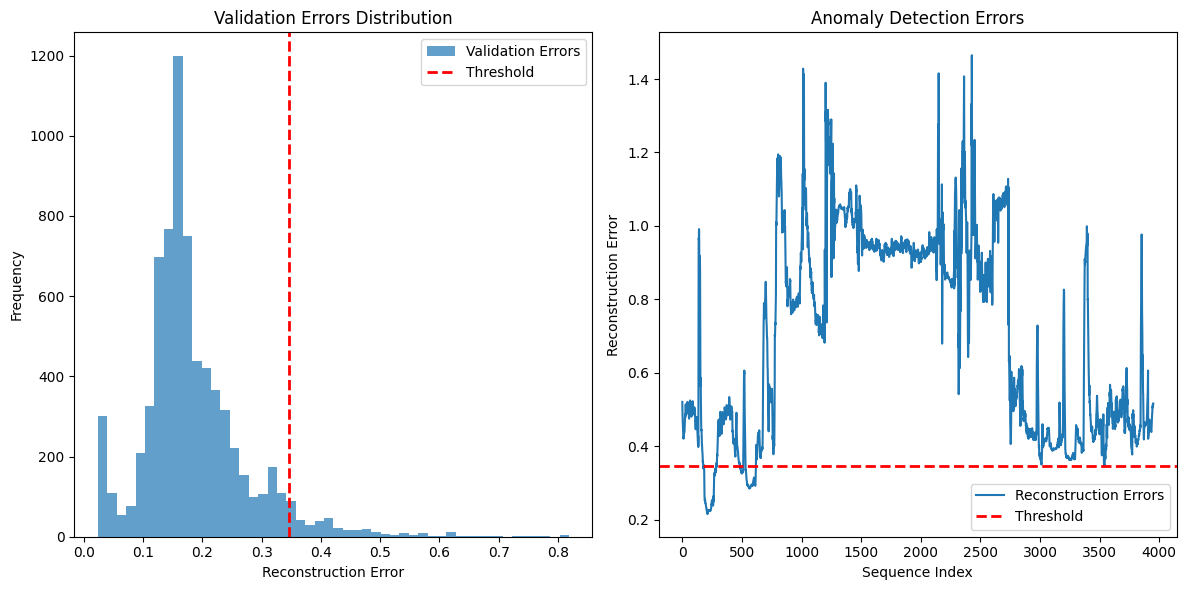

Detected 3727 anomalies out of 3951 sequences


In [8]:
# Detect anomaly robot joint
anomaly_data = load_csv(ANOMALY_DATA_PATH)
anomaly_errors, is_anomaly = detector.detect_anomalies(anomaly_data)

# Plot anomalies
detector.plot_anomalies(val_errors, anomaly_errors)

print(f"Detected {is_anomaly.sum()} anomalies out of {len(is_anomaly)} sequences")